In [2]:
import random
import numpy as np

random.seed(42)
np.random.seed(42)

import networkx as nx

def build_true_graph():
    """
    Builds a small DAG:
       Omega -> A
       A -> B
       A -> C
       Omega -> D
       Omega -> E
       E -> F

    with known "true" edge probabilities w_true.
    """
    G = nx.DiGraph()
    nodes = ["Omega","A","B","C","D","E","F"]
    G.add_nodes_from(nodes)


    G.add_edge("Omega","A")
    G.add_edge("A","B")
    G.add_edge("A","C")
    G.add_edge("Omega","D")
    G.add_edge("Omega","E")
    G.add_edge("E","F")

    w_true = {
        ("Omega","A"): 0.3,
        ("Omega","D"): 0.2,
        ("Omega","E"): 0.5,  
        ("A","B"): 0.4,
        ("A","C"): 0.5,     
        ("E","F"): 0.7       
    }

    return G, w_true

def compute_distribution(G, root, w_dict):
    """
    Given a DAG G, root, and a dict of edge probabilities w_dict, compute the
    absorption distribution Y for each node via a forward pass.
    
    The absorption at node j is: p_in[j]*(1 - sum_{children} w_dict[j->child]).
    """
    all_nodes = list(nx.topological_sort(G))
    p_in = {n: 0.0 for n in all_nodes}
    p_in[root] = 1.0

    # pass in topological order
    for u in all_nodes:
        out_edges = list(G.out_edges(u))
        for (u,v) in out_edges:
            prob_uv = w_dict.get((u,v), 0.0)
            p_in[v] += p_in[u]*prob_uv

    Y = {}
    for j in all_nodes:
        sum_out = sum(w_dict.get((j,c), 0.0) for c in G.successors(j))
        alpha_j = max(0.0, 1.0 - sum_out)  # "absorption" fraction
        Y[j] = p_in[j]*alpha_j
    return Y

true_graph, w_true = build_true_graph()
Y = compute_distribution(true_graph, "Omega", w_true)
Y

{'Omega': 0.0,
 'A': 0.029999999999999992,
 'D': 0.2,
 'E': 0.15000000000000002,
 'B': 0.12,
 'C': 0.15,
 'F': 0.35}

In [3]:
from solver_gd import run_gradient_descent

theta_dict, Yhat_dict, loss_history, theta_history = run_gradient_descent(true_graph, Y, "Omega", num_epochs=100)
Yhat_dict

Epoch 10/100, loss=0.012290
Epoch 20/100, loss=0.002061
Epoch 30/100, loss=0.001305
Epoch 40/100, loss=0.000756
Epoch 50/100, loss=0.000492
Epoch 60/100, loss=0.000334
Epoch 70/100, loss=0.000269
Epoch 80/100, loss=0.000237
Epoch 90/100, loss=0.000214
Epoch 100/100, loss=0.000198


{'Omega': 0.01293985452502966,
 'A': 0.027302894741296768,
 'D': 0.19820693135261536,
 'E': 0.14753495156764984,
 'B': 0.1177789717912674,
 'C': 0.1477978676557541,
 'F': 0.3484385907649994}

In [4]:
def compute_deviation(w_true, w_hat):
    all_edges = set(w_true.keys()) | set(w_hat.keys())

    deviation = 0.0
    for edge in all_edges:
        w1 = w_true.get(edge, 0.0)
        w2 = w_hat.get(edge, 0.0)
        deviation += abs(w1 - w2)

    return deviation

deviations = [compute_deviation(theta_history[i], w_true) for i in range(len(theta_history))]

print(deviations)


[0.6158760160207748, 0.4579119652509689, 0.38171204924583435, 0.30799931287765503, 0.2819438040256501, 0.2666721999645234, 0.24108763635158548, 0.23351229429245002, 0.24778285324573524, 0.24906527698040015, 0.24643169641494755, 0.24366089999675755, 0.23373438715934758, 0.23341935873031616, 0.22287234663963318, 0.20215904712677002, 0.17361600697040558, 0.1403409242630005, 0.11353392302989962, 0.10292302370071416, 0.10211145579814906, 0.1188093245029449, 0.12511539161205287, 0.12221360504627221, 0.12516348361968987, 0.12327866554260247, 0.12590633630752557, 0.12573280334472647, 0.12779287397861472, 0.12505739331245413, 0.1182622402906417, 0.12005467712879181, 0.1214771717786789, 0.11718741059303284, 0.1079673171043396, 0.09497448801994324, 0.08887439966201782, 0.08403249084949493, 0.07984694242477419, 0.07850361168384556, 0.07882030606269841, 0.07522158622741704, 0.06813611388206486, 0.06032653450965875, 0.05954543054103845, 0.05815564393997186, 0.05636041164398187, 0.06137627661228173, 

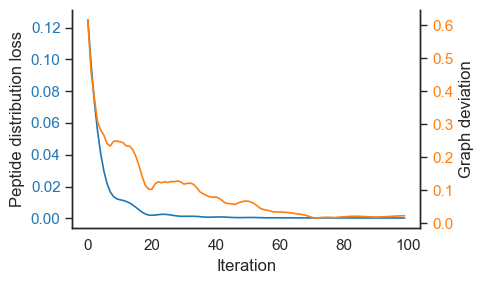

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("white")
sns.set_context("paper", font_scale=1.25)
fig, ax1 = plt.subplots(figsize=(5,3))

color_left = "tab:blue"
sns.lineplot(x=range(len(theta_history)), y=loss_history, ax=ax1, color=color_left)
ax1.set_xlabel("Iteration")
ax1.set_ylabel("Peptide distribution loss")
ax1.tick_params(axis='y', labelcolor=color_left)

ax2 = ax1.twinx()

color_right = "tab:orange"
sns.lineplot(x=range(len(deviations)), y=deviations, ax=ax2, color=color_right)
ax2.set_ylabel("Graph deviation")
ax2.tick_params(axis='y', labelcolor=color_right)

sns.despine(top=True, right=False)
plt.tight_layout()